## Example InfluxDB Jupyter notebook. 

This example demonstrates how to query data from InfluxDB 2.0 using Flux and predict the stock price. 
(ML example using Keras)


### Prerequisites

* import testing dataset before running this notebook using `python3 ./stock_predictions_import_data.py`
* install fallowing dependencies
    * pip3 install keras
    * pip3 install matplotlib
    * pip3 install pyplot
    * pip3 install tensorflow
    * pip3 install sklearn

In [1]:
from __future__ import print_function

import math
import os

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

from influxdb_client import InfluxDBClient
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

Using TensorFlow backend.


In [2]:
# parameters to be set ("optimum" hyperparameters obtained from grid search):
look_back = 7
epochs = 100
batch_size = 32

In [3]:
# fix random seed for reproducibility
np.random.seed(7)

# read all prices using panda
#prices_dataset =  pd.read_csv('./prices-split-adjusted.csv', header=0)

# read prices from InfluxDB 2.0 
client = InfluxDBClient(url="http://localhost:9999", token="my-token", org="my-org", debug=False)
query='''
from(bucket:"my-bucket")
        |> range(start: 0, stop: now())
        |> filter(fn: (r) => r._measurement == "financial-analysis")
        |> filter(fn: (r) => r.symbol == "AAPL")
        |> filter(fn: (r) => r._field == "close")
        |> drop(columns: ["_start", "result", "_stop", "table", "_field","_measurement"])
        |> rename(columns: {_value: "close"})
'''
prices_dataset = client.query_api().query_data_frame(org="my-org", query=query)
display(prices_dataset.head())

# save Apple's stock values as type of floating point number
apple_stock_prices = prices_dataset.close.values.astype('float32')

,result,table,_time,close,symbol
0,_result,0,2010-01-04 00:00:00+00:00,30.572857,AAPL
1,_result,0,2010-01-05 00:00:00+00:00,30.625713,AAPL
2,_result,0,2010-01-06 00:00:00+00:00,30.138571,AAPL
3,_result,0,2010-01-07 00:00:00+00:00,30.082857,AAPL
4,_result,0,2010-01-08 00:00:00+00:00,30.282858,AAPL


In [4]:
# reshape to column vector
apple_stock_prices = apple_stock_prices.reshape(len(apple_stock_prices), 1)

# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
apple_stock_prices = scaler.fit_transform(apple_stock_prices)

In [5]:
# split data into training set and test set
train_size = int(len(apple_stock_prices) * 0.67)
test_size = len(apple_stock_prices) - train_size
train, test = apple_stock_prices[0:train_size,:], apple_stock_prices[train_size:len(apple_stock_prices),:]

print('Split data into training set and test set... Number of training samples/ test samples:', len(train), len(test))

Split data into training set and test set... Number of training samples/ test samples: 1180 582


In [6]:
# convert an array of values into a time series dataset 
# in form 
#                     X                     Y
# t-look_back+1, t-look_back+2, ..., t     t+1

def create_dataset(dataset, look_back):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

# convert Apple's stock price data into time series dataset
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input of the LSTM to be format [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [7]:
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(look_back, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
model.fit(trainX, trainY, nb_epoch=epochs, batch_size=batch_size)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  import sys


Epoch 1/100
1172/1172 [==============================] - 1s 519us/step - loss: 0.0559
Epoch 2/100
1172/1172 [==============================] - 0s 163us/step - loss: 0.0163
Epoch 3/100
1172/1172 [==============================] - 0s 189us/step - loss: 0.0089
Epoch 4/100
1172/1172 [==============================] - 0s 160us/step - loss: 0.0063
Epoch 5/100
1172/1172 [==============================] - 0s 145us/step - loss: 0.0040
Epoch 6/100
1172/1172 [==============================] - 0s 174us/step - loss: 0.0023
Epoch 7/100
1172/1172 [==============================] - 0s 134us/step - loss: 0.0012
Epoch 8/100
1172/1172 [==============================] - 0s 177us/step - loss: 7.6649e-04
Epoch 9/100
1172/1172 [==============================] - 0s 136us/step - loss: 6.0999e-04
Epoch 10/100
1172/1172 [==============================] - 0s 140us/step - loss: 5.6453e-04
Epoch 11/100
1172/1172 [==============================] - 0s 138us/step - loss: 5.4008e-04
Epoch 12/100
1172/1172 [============

In [8]:

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

In [9]:
# invert predictions and targets to unscaled
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [10]:
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 1.79 RMSE
Test Score: 6.60 RMSE


In [11]:
# shift predictions of training data for plotting
trainPredictPlot = np.empty_like(apple_stock_prices)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift predictions of test data for plotting
testPredictPlot = np.empty_like(apple_stock_prices)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(apple_stock_prices)-1, :] = testPredict

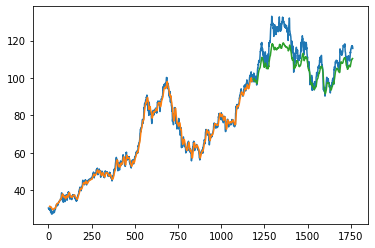

In [12]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(apple_stock_prices))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()